In [3]:
!pip install openai pinecone-client supabase


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [1]:
from supabase import create_client, Client
import datetime

from typing import Dict, Optional, Any
from openai import OpenAI
import pandas as pd

from pydantic import BaseModel, Field
from typing import List, Dict, Tuple

In [4]:
import os

In [14]:
url: str = os.environ['SUPABASE_URL']
key: str = os.environ['SUPABASE_KEY']
supabase: Client = create_client(url, key)

In [15]:
client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

class ChatLLM(BaseModel):
    model: str = 'gpt-3.5-turbo'
    temperature: float = 0.0

    def generate(self, prompt: str, stop: List[str] = None):
        response = client.chat.completions.create(
            model=self.model,
            messages=[{"role": "user", "content": prompt}],
            temperature=self.temperature,
            stop=stop
        )
        supabase.table('cost_projecting').insert({
            'prompt': prompt,
            'response': response.choices[0].message.content,
            'input_tokens': response.usage.prompt_tokens,
            'output_tokens': response.usage.completion_tokens,
            'model': self.model,
            'inference_params' : {
                'temperature': self.temperature,
                'stop': stop
            },
            'is_openai': True,
            'app': 'RAG'
        }).execute()
        return response.choices[0].message.content

In [16]:
c = ChatLLM()
c.generate('hi')

'Hello! How can I assist you today?'

In [17]:
pinecone_key = os.environ['PINECONE_API_KEY']
INDEX_NAME = 'semantic-search-health-idx'
ENGINE = 'text-embedding-3-large'  # has size 3072
NAMESPACE = 'default'

from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(
    api_key=pinecone_key
)
# helper functions to get lists of embeddings from the OpenAI API
def get_embeddings(texts, engine=ENGINE):
    response = client.embeddings.create(
        input=texts,
        model=engine
    )

    return [d.embedding for d in list(response.data)]

def get_embedding(text, engine=ENGINE):
    return get_embeddings([text], engine)[0]

len(get_embedding('hi')), len(get_embeddings(['hi', 'hello']))

(3072, 2)

In [18]:
import hashlib
def my_hash(s):
    # Return the MD5 hash of the input string as a hexadecimal string
    return hashlib.md5(s.encode()).hexdigest()

my_hash('I love to hash it')

'ae76cc4dfd345ecaeea9b8ba0d5c3437'

In [19]:
# Store the index as a variable
index = pc.Index(name=INDEX_NAME)
index

In [20]:
def query_from_pinecone(query, top_k=1, include_metadata=True):
    # get embedding from THE SAME embedder as the documents
    query_embedding = get_embedding(query, engine=ENGINE)

    return index.query(
      vector=query_embedding,
      top_k=top_k,
      namespace=NAMESPACE,
      include_metadata=include_metadata   # gets the metadata (dates, text, etc)
    ).get('matches')

query_from_pinecone('In what year did Scipione Riva-Rocci invent the sphygmomanometer?')

[{'id': '2f0c097b3678a7fddc698513533b3edb',
  'metadata': {'date_uploaded': '2024-04-03T16:13:11.908995',
               'text': 'Modern understanding of the cardiovascular system began '
                       'with the work of physician William Harvey (1578–1657), '
                       'who described the circulation of blood in his book "De '
                       'motu cordis". The English clergyman Stephen Hales made '
                       'the first published measurement of blood pressure in '
                       '1733.  However, hypertension as a clinical entity came '
                       'into its own with the invention of the cuff-based '
                       'sphygmomanometer by Scipione Riva-Rocci in 1896. This '
                       'allowed easy measurement of systolic pressure in the '
                       'clinic. In 1905, Nikolai Korotkoff improved the '
                       'technique by describing the Korotkoff sounds that are '
                    

In [21]:
FINAL_ANSWER_TOKEN = "Assistant Response:"
STOP = '[END]'
PROMPT_TEMPLATE = """Today is {today} and you can retrieve information from a database. Response the user's input as best as you can.

Here is an example of the conversation format:

[START]
User Input: the input question you must answer
Context: retrieved context from the database
Context Score : a score from 0 - 1 of how strong the information is a match
Assistant Thought: This context has sufficient information to answer the question.
Assistant Response: your final answer to the original input question which could be I don't have sufficient information to answer the question.
[END]
[START]
User Input: another input question you must answer
Context: more retrieved context from the database
Context Score : another score from 0 - 1 of how strong the information is a match
Assistant Thought: This context does not have sufficient information to answer the question.
Assistant Response: your final answer to the second input question which could be I don't have sufficient information to answer the question.
[END]

Begin:

{running_convo}
"""

class RagBot(BaseModel):
    llm: ChatLLM
    prompt_template: str = PROMPT_TEMPLATE
    stop_pattern: List[str] = [STOP]
    user_inputs: List[str] = []
    ai_responses: List[str] = []
    contexts: List[Tuple[str, float]] = []
    verbose: bool = False

    def query_from_pinecone(self, query, top_k=1, include_metadata=True):
        return query_from_pinecone(query, top_k, include_metadata)

    @property
    def running_convo(self):
        convo = ''
        for index in range(len(self.user_inputs)):
            convo += f'[START]\nUser Input: {self.user_inputs[index]}\n'
            convo += f'Context: {self.contexts[index][0]}\nContext Score: {self.contexts[index][1]}\n'
            if len(self.ai_responses) > index:
                convo += self.ai_responses[index]
                convo += '\n[END]\n'
        return convo.strip()

    def run(self, question: str):
        self.user_inputs.append(question)
        top_response = self.query_from_pinecone(question)[0]
        # if top_response['score'] < .07:
        #     pass # do something about it
        self.contexts.append(
            (top_response['metadata']['text'], top_response['score']))

        prompt = self.prompt_template.format(
                today = datetime.date.today(),
                running_convo=self.running_convo
        )
        generated = self.llm.generate(prompt, stop=self.stop_pattern)
        self.ai_responses.append(generated)
        if FINAL_ANSWER_TOKEN in generated:
            generated = generated.split(FINAL_ANSWER_TOKEN)[-1]
        return generated

In [22]:
r = RagBot(llm=ChatLLM(temperature=0.0), stop_pattern=['[END]'])
print(r.run('In what year did Scipione Riva-Rocci invent the sphygmomanometer?'))

 Scipione Riva-Rocci invented the sphygmomanometer in the year 1896.


In [23]:
print(r.run('How old is Obama'))

 I don't have sufficient information to answer the question about Obama's age.


In [24]:
print(r.running_convo)

[START]
User Input: In what year did Scipione Riva-Rocci invent the sphygmomanometer?
Context: Modern understanding of the cardiovascular system began with the work of physician William Harvey (1578–1657), who described the circulation of blood in his book "De motu cordis". The English clergyman Stephen Hales made the first published measurement of blood pressure in 1733.  However, hypertension as a clinical entity came into its own with the invention of the cuff-based sphygmomanometer by Scipione Riva-Rocci in 1896. This allowed easy measurement of systolic pressure in the clinic. In 1905, Nikolai Korotkoff improved the technique by describing the Korotkoff sounds that are heard when the artery is ausculted with a stethoscope while the sphygmomanometer cuff is deflated. This permitted systolic and diastolic pressure to be measured.
Context Score: 0.600845695
Assistant Thought: The context provides a direct answer to the user's question.
Assistant Response: Scipione Riva-Rocci invented

In [21]:
def chat_with(chatbot):
# Chat loop
    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit"]:
            break
        response = chatbot.run(user_input)
        print("Bot:", response)

    # After exiting the loop, print all AI responses
    print("\nAI Responses:")
    print(chatbot.running_convo)

In [23]:
chatbot = RagBot(llm=ChatLLM(temperature=0.0), verbose=False)
chat_with(chatbot)

You:  In what year did Scipione Riva-Rocci invent the sphygmomanometer?


Bot:  Scipione Riva-Rocci invented the sphygmomanometer in the year 1896.


You:  who are you/


Bot:  I am an AI assistant here to help answer your questions and provide information.


You:  amazing, what year is it?


Bot:  I don't have sufficient information to answer the question about the current year.


You:  exit



AI Responses:
[START]
User Input: In what year did Scipione Riva-Rocci invent the sphygmomanometer?
Context: Modern understanding of the cardiovascular system began with the work of physician William Harvey (1578–1657), who described the circulation of blood in his book "De motu cordis". The English clergyman Stephen Hales made the first published measurement of blood pressure in 1733.  However, hypertension as a clinical entity came into its own with the invention of the cuff-based sphygmomanometer by Scipione Riva-Rocci in 1896. This allowed easy measurement of systolic pressure in the clinic. In 1905, Nikolai Korotkoff improved the technique by describing the Korotkoff sounds that are heard when the artery is ausculted with a stethoscope while the sphygmomanometer cuff is deflated. This permitted systolic and diastolic pressure to be measured.
Context Score: 0.600765705
Assistant Thought: The context provides a clear answer to the question about the invention of the sphygmomanomete

In [25]:
response = supabase.table('cost_projecting').select("*").eq('app', 'RAG').execute()
completions_df = pd.DataFrame(response.data)
completions_df.index = pd.to_datetime(completions_df['created_at'])

completions_df.head()

,id,created_at,prompt,response,model,is_openai,input_tokens,output_tokens,inference_params,app
created_at,,,,,,,,,,
2024-03-18 19:24:56.134185+00:00,5,2024-03-18T19:24:56.134185+00:00,Today is 2024-03-18 and you can retrieve infor...,Assistant Thought: The context provided is abo...,gpt-3.5-turbo,True,285,39,"{'stop': ['[END]'], 'temperature': 0.0}",RAG
2024-03-18 19:24:16.392024+00:00,4,2024-03-18T19:24:16.392024+00:00,Today is 2024-03-18 and you can retrieve infor...,Assistant Thought: This context does not have ...,gpt-3.5-turbo,True,403,36,"{'stop': ['[END]'], 'temperature': 0.0}",RAG
2024-03-18 19:24:14.813647+00:00,3,2024-03-18T19:24:14.813647+00:00,Today is 2024-03-18 and you can retrieve infor...,Assistant Thought: This context has sufficient...,gpt-3.5-turbo,True,288,41,"{'stop': ['[END]'], 'temperature': 0.0}",RAG
2024-03-18 19:25:00.481563+00:00,6,2024-03-18T19:25:00.481563+00:00,Today is 2024-03-18 and you can retrieve infor...,Assistant Thought: The context provided is abo...,gpt-3.5-turbo,True,388,52,"{'stop': ['[END]'], 'temperature': 0.0}",RAG
2024-03-26 19:37:42.651757+00:00,126,2024-03-26T19:37:42.651757+00:00,<s>[INST] <<SYS>> You are a helpful assistant....,The current President of Gabon is Ali Bongo On...,meta-llama/Llama-2-7b-chat-hf,False,32,111,"{'stop': None, 'temperature': 0.3}",RAG


In [26]:
prices = { # per 1M tokens
    'gpt-3.5-turbo': {
        'prompt': 0.5,
        'completion': 1.5
    }
}

def calculate_cost(input_tokens, output_tokens, model):
    if model not in prices:
        return None

    prompt_cost = input_tokens / 1e6
    completion_cost = output_tokens / 1e6

    return prompt_cost + completion_cost

calculate_cost(354, 400, 'gpt-3.5-turbo')

0.000754

In [27]:
# run calculate_cost over every row
completions_df['cost'] = completions_df.apply(
    lambda row: calculate_cost(row['input_tokens'], row['output_tokens'], row['model']), axis=1
    )

In [28]:
completions_df['cost'].resample('W').sum().sort_index()

created_at
2024-03-24 00:00:00+00:00    0.001532
2024-03-31 00:00:00+00:00    0.002632
2024-04-07 00:00:00+00:00    0.003777
2024-04-14 00:00:00+00:00    0.001044
Freq: W-SUN, Name: cost, dtype: float64

<Axes: xlabel='created_at'>

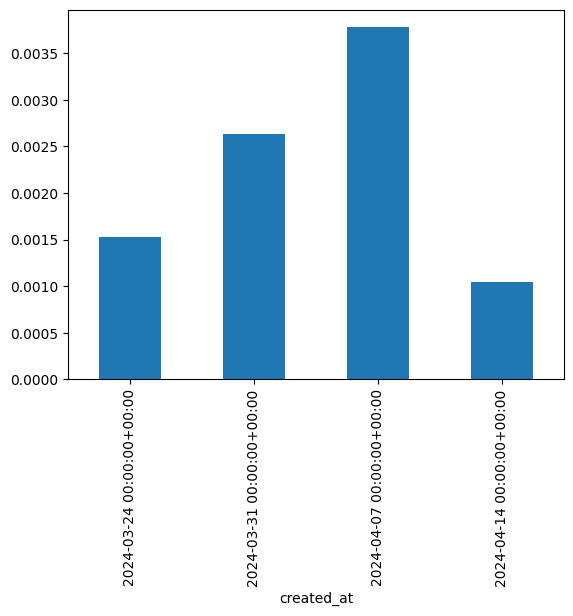

In [29]:
completions_df['cost'].resample('W').sum().sort_index().plot(kind='bar')

In [30]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("nousresearch/llama-2-13b-chat-hf")

In [48]:
import requests

INSTRUCT_API_URL = "https://xvlp6ehdc08woe9p.us-east-1.aws.endpoints.huggingface.cloud"
headers = {
	"Accept" : "application/json",
	"Authorization": "Bearer "+ userdata.get("HF_TOKEN"),
	"Content-Type": "application/json"
}

class LlamaChatLLM(ChatLLM):
    model: str = 'meta-llama/Llama-2-13b-chat-hf'
    temperature: float = 0.3
    do_sample: bool = True
    max_new_tokens: int = 256

    def generate(self, prompt: str, stop: List[str] = None):
        def query(payload, url):
            response = requests.post(url, headers=headers, json=payload)
            return response.json()

        system_prompt = """You are a helpful assistant.""".strip()
        _input = f"<s>[INST] <<SYS>> {system_prompt} <</SYS>> {prompt} [/INST]"
        _input = prompt
        response = query({
            "inputs": _input,
            "parameters": {
                "temperature": self.temperature,
                "do_sample": self.do_sample,
                "max_new_tokens": self.max_new_tokens
            }
        }, url=INSTRUCT_API_URL)

        if type(response) == dict and response.get('error'):
            raise ValueError(response.get('error'))
        response = response[0]['generated_text'].strip()
        response = response.split(_input)[-1].strip()
        for s in stop:
            if s in response:
                response = response.split(s)[0].strip()
                break
        supabase.table('cost_projecting').insert({
            'prompt': _input,
            'response': response,
            'input_tokens': len(tokenizer(_input)['input_ids']),
            'output_tokens': len(tokenizer(response)['input_ids']),
            'model': self.model,
            'inference_params' : {
                'temperature': self.temperature,
                'stop': stop
            },
            'is_openai': False,
            'app': 'RAG'
        }).execute()
        return response

In [50]:
llama_llm = LlamaChatLLM(temperature=0.05)
chat_with(RagBot(llm=llama_llm, verbose=False, stop_pattern=['[END]']))

You:  In what year did Scipione Riva-Rocci invent the sphygmomanometer?


Bot:  Scipione Riva-Rocci invented the sphygmomanometer in 1896.


You:  how old is Obama/


Bot:  I don't have sufficient information to answer the question.


You:  who are you?


Bot:  I don't have sufficient information to answer the question.


You:  exit



AI Responses:
[START]
User Input: In what year did Scipione Riva-Rocci invent the sphygmomanometer?
Context: Modern understanding of the cardiovascular system began with the work of physician William Harvey (1578–1657), who described the circulation of blood in his book "De motu cordis". The English clergyman Stephen Hales made the first published measurement of blood pressure in 1733.  However, hypertension as a clinical entity came into its own with the invention of the cuff-based sphygmomanometer by Scipione Riva-Rocci in 1896. This allowed easy measurement of systolic pressure in the clinic. In 1905, Nikolai Korotkoff improved the technique by describing the Korotkoff sounds that are heard when the artery is ausculted with a stethoscope while the sphygmomanometer cuff is deflated. This permitted systolic and diastolic pressure to be measured.
Context Score: 0.600845695
Assistant Thought: This context has sufficient information to answer the question.
Assistant Response: Scipione R